# Import

In [13]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pyvis.network import Network
from IPython.display import HTML, display
from gensim.models.poincare import PoincareModel

from src.load_datasets import load_dataset, load_rankings
from src.encoding import load_graph

In [2]:
# figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set()
sns.set(style='whitegrid', )
#sns.set_palette(palette="Set2")
sns.set_palette(palette="Paired")

# set seed
np.random.seed(7)

# Get data

In [3]:
dataset = load_dataset('../../data/raw/dataset.csv')
rankings = load_rankings('../../data/raw/rankings.csv')

Loading data ...
Loading rankings ...


# Get graph

In [4]:
# get graph as networkx graph
G = load_graph("../../data/raw/graph.adjlist")
# show some information about the graph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")

Number of nodes: 45
Number of edges: 44


### Visualize the graph

In [5]:
# create a Pyvis Network instance
nt = Network(heading="Hierarchical Structure Feature Encoder", notebook=True, cdn_resources='in_line')
# add nodes and edges to the Pyvis Network
nt.from_nx(G)
# show the Pyvis Network
html = nt.generate_html('encoder_graph.html')
with open("encoder_graph.html", mode='w', encoding='utf-8') as fp:
        fp.write(html)
display(HTML(html))

### Vector representations of those no de labels plotted on a 2d scatter graph

In [6]:
def calculate_level(G):
    """
    Generates the feature hierarchical level for each node in the graph. Where the level defines the depth of the node in the graph hierarchy.

    :param G: The input graph.
    :type G: networkx.Graph

    :return: The graph with the hierarchical level.
    """
    levels = {}  # Dictionary to store hierarchical levels of nodes

    # Iterate over all nodes in the graph and calculate their hierarchical levels
    for node in G.nodes:
        if G.degree(node) == 0:
            levels[node] = 0
        else:
            max_level = 0
            for neighbor in G.neighbors(node):
                if neighbor in levels:
                    max_level = max(max_level, levels[neighbor] + 1)
            levels[node] = max_level

    # Add the hierarchical level as an attribute to each node in the graph
    nx.set_node_attributes(G, levels, "hierarchical_level")

    return G

In [7]:
# Get hierarchical level for each node
G = calculate_level(G)

In [8]:
# Print the hierarchical level for all nodes
for node, data in G.nodes(data=True):
    level = data["hierarchical_level"]
    print("Node:", node, "Level:", level)

Node: BE Level: 0
Node: identifier Level: 1
Node: BUCV10RGLMME Level: 0
Node: bucvglmm Level: 1
Node: BUCV10TE Level: 0
Node: bucvte Level: 1
Node: BUCV2RGLMME Level: 2
Node: BUCV2TE Level: 2
Node: BUCV5RGLMME Level: 2
Node: BUCV5TE Level: 2
Node: CBE Level: 0
Node: supervised Level: 1
Node: CE Level: 0
Node: unsupervised Level: 2
Node: CV10RGLMME Level: 0
Node: cvglmm Level: 1
Node: CV10TE Level: 0
Node: cvte Level: 1
Node: CV2RGLMME Level: 2
Node: CV2TE Level: 2
Node: CV5RGLMME Level: 2
Node: CV5TE Level: 2
Node: DE Level: 3
Node: DTEM10 Level: 0
Node: dte Level: 2
Node: DTEM2 Level: 3
Node: DTEM5 Level: 3
Node: ME01E Level: 0
Node: mee Level: 2
Node: ME10E Level: 3
Node: ME1E Level: 3
Node: MHE Level: 3
Node: OE Level: 2
Node: OHE Level: 2
Node: PBTE0001 Level: 0
Node: pbte Level: 2
Node: PBTE001 Level: 3
Node: PBTE01 Level: 3
Node: RGLMME Level: 0
Node: glmm Level: 2
Node: SE Level: 3
Node: TE Level: 0
Node: te Level: 2
Node: WOEE Level: 2
Node: encoder Level: 3


In [9]:
# Get the position of each node in the graph
pos = nx.spring_layout(G, k=0.5, iterations=50)

In [10]:
# Extract x and y coordinates and combine with the level attribute
graph_df = pd.DataFrame.from_dict(pos, orient='index', columns=['x', 'y'])
graph_df['level'] = nx.get_node_attributes(G, 'hierarchical_level')

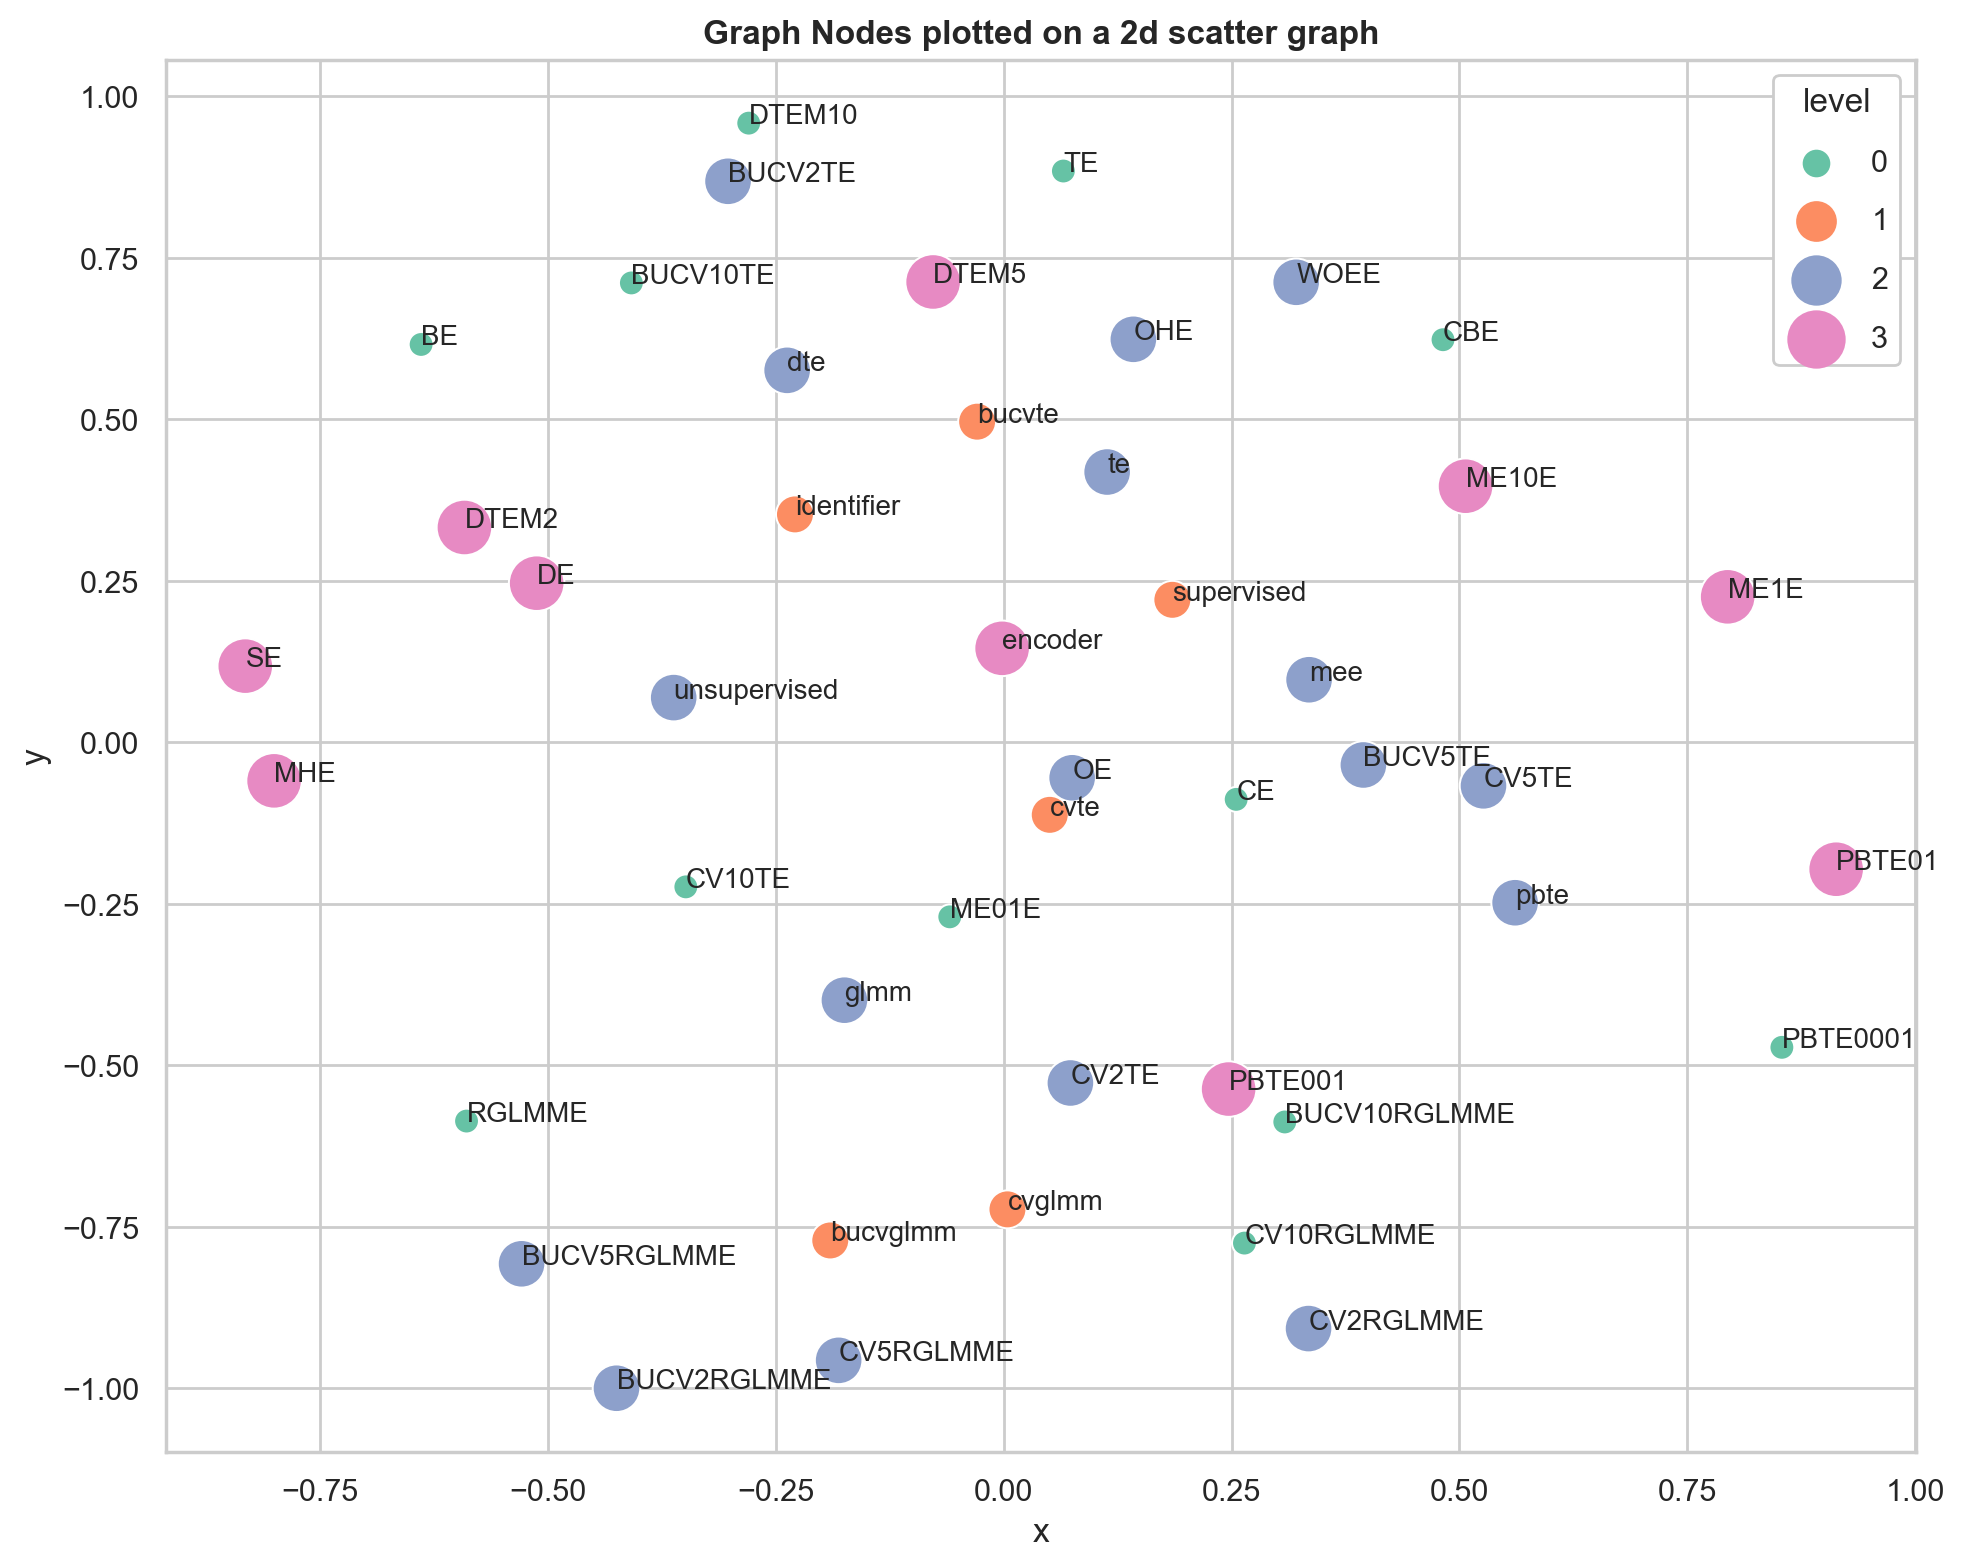

In [31]:
with plt.rc_context({"legend.labelspacing": 1.0, 'legend.frameon':True, 'legend.framealpha':1.0}):
    # Make scatter plot of the nodes
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=graph_df, x='x', y='y', hue='level', size='level', sizes=(80, 400), palette="Set2")
    # Add node labels as annotations to the plot
    for node, (x, y) in pos.items():
        plt.text(x, y, node, fontsize=10)
    # Add title to the plot
    plt.title('Graph Nodes plotted on a 2d scatter graph', fontweight='bold')
    # Show plot
    plt.tight_layout()
    plt.show()

# Pointcarè embedding
We want to encode the feature encoder using the [Pointcarè Embedding](https://radimrehurek.com/gensim/models/poincare.html). By doing this we encode the hierarchical structure of the feature encoder and preserve it. The graph with the hierarchical structure is given in [data/raw](../../data/raw), the library networkx is used to load the graph.

Hierarchies are often trees where the number of nodes increases exponentially by the level, so we want a space that increases exponentially as we deviate from the “origin” of the space. The Poincaré ball follows this property, so we can define our vectors on this space. We define a loss function that gives a good score for clustering vectors in the same hierarchy and spreading out vectors in different hierarchies. Finally, we can find vectors to minimize our loss function using Riemann gradient descent and get a good numerical representation of the words being the name of the encoders.

The method is described in [Maximilian Nickel, Douwe Kiela - “Poincaré Embeddings for Learning Hierarchical Representations”](https://arxiv.org/abs/1705.08039)

In [ ]:
%%time
# embed the graph
model = PoincareModel(G, size=2, negative=2)
# build encoder wit the embedding
model.train(epochs=10)
# plot the embedding in an 2d scatter plot
model.plot()

In [ ]:
# embed the graph
# n2v = Node2Vec(G, dimensions=2, walk_length=20, num_walks=1000, workers=1, quiet=True)
# embedding = n2v.fit().wv.vectors
# ...  You can then build an encoder with the embedding
# ... If you embed in 2d, you can plot an annotatate scatter plot of the embedding to see if it worked as expected